In [1]:
import os
import sqlite3
import re
from datetime import datetime

# Caminho para o banco de dados
DB_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 
                     'data_warehouse', 'stellar_occultations.db')

import astro_data_access as astro_data_access

Utilizaremos o arquivo "astro_data_access.py" como nossa biblioteca pessoal para manipularmos os dados do nosso DB. Nela teremos todo o ferramental necessário para organizarmos nosso dataset!

## 1 - Primeiro passo
Interagir com a Data Base. Buscar objetos e curvas, plotá-las e analisá-las

In [2]:
astro_data_access.get_available_objects()

['1983VD7',
 '1991TF1',
 '1994XM2',
 '1998XA53',
 '1999PY3',
 '1999RU208',
 '1999TA91',
 '1999TB100',
 '1999TG246',
 '1999XR13',
 '1999XW211',
 '2000ET64',
 '2000HT75',
 '2000KJ1',
 '2000OW26',
 '2000SW106',
 '2000TK17',
 '2000WV132',
 '2001HS35',
 '2001US197',
 '2002KX14',
 '2002WC19',
 '2003GG42',
 '2003UP55',
 '2005RM43',
 '2007JJ43',
 '2014EZ51',
 'Abundantia',
 'Academia',
 'Adelheid',
 'Adelinda',
 'Admete',
 'Adorea',
 'Adria',
 'Adzhimushkaj',
 'Aegina',
 'Aegle',
 'Aeternitas',
 'Aethra',
 'Aguntina',
 'Aida',
 'Alauda',
 'Alekto',
 'Alemannia',
 'Aletheia',
 'Alfven',
 'Aline',
 'Alkmene',
 'Alphonsina',
 'Alsatia',
 'Althaea',
 'Amalia',
 'Amalthea',
 'Amata',
 'Ambrosia',
 'Anacostia',
 'Angola',
 'Ani',
 'Antenor',
 'Antigone',
 'Antilochus',
 'Antiope',
 'Antonia',
 'Arctica',
 'Arethusa',
 'Armida',
 'Artemis',
 'Asia',
 'Aspasia',
 'Asplinda',
 'Asterope',
 'Atala',
 'Atalante',
 'Ate',
 'Athamantis',
 'Aulis',
 'Aurelia',
 'Aurora',
 'Ausonia',
 'Austria',
 'Backlunda'

In [3]:
objects = astro_data_access.get_available_objects()

# Demonstração com o primeiro objeto
selected_object = objects[:2]
selected_object

['1983VD7', '1991TF1']

In [4]:
dates = [astro_data_access.get_observation_dates(object) for object in selected_object]
dates

[['2020-11-01'], ['2020-11-01']]

In [5]:
astro_data_access.search_light_curves(selected_object[0], dates[0][0])

[{'observation_id': 1,
  'observer_name': 'JordiMarco',
  'is_positive': True,
  'point_count': 1198}]

In [6]:
lcs = []
for ind_objt in range(len(selected_object)):
    for date in dates[ind_objt]:
        lcs.append(astro_data_access.search_light_curves(selected_object[ind_objt], date))
lcs

[[{'observation_id': 1,
   'observer_name': 'JordiMarco',
   'is_positive': True,
   'point_count': 1198}],
 [{'observation_id': 2,
   'observer_name': 'DHerald',
   'is_positive': True,
   'point_count': 826},
  {'observation_id': 3,
   'observer_name': 'WHanna',
   'is_positive': True,
   'point_count': 281}]]

In [7]:
lcs = [astro_data_access.search_light_curves(selected_object[ind_objt], date) 
       for ind_objt in range(len(selected_object)) 
       for date in dates[ind_objt]]
lcs

[[{'observation_id': 1,
   'observer_name': 'JordiMarco',
   'is_positive': True,
   'point_count': 1198}],
 [{'observation_id': 2,
   'observer_name': 'DHerald',
   'is_positive': True,
   'point_count': 826},
  {'observation_id': 3,
   'observer_name': 'WHanna',
   'is_positive': True,
   'point_count': 281}]]

1) buscar forma de plotar as curvas que estão sendo analisadas
2) buscar forma que recortar a parte negativa automática das curvas positivas
3) guardar essas negativas extras em um dataset a parte
4) organizar e modular o dataset final para que possa ser aplicado no script model train

In [8]:
objects = astro_data_access.get_available_objects()

# Demonstração com o primeiro objeto
selected_object = objects[:2]
print(f"\nDatas disponíveis para {selected_object}:")

dates = [astro_data_access.get_observation_dates(object) for object in selected_object]
for date in dates:
    print(f"- {date} Encontrada")

light_curves = [astro_data_access.search_light_curves(selected_object[ind_objt], date) 
       for ind_objt in range(len(selected_object)) 
       for date in dates[ind_objt]]

for list in light_curves:
    for lc in list:
        print(f"- {lc.get('observer_name')} (Positivo: {lc.get('is_positive')}, Pontos: {lc.get('point_count')})")


Datas disponíveis para ['1983VD7', '1991TF1']:
- ['2020-11-01'] Encontrada
- ['2020-11-01'] Encontrada
- JordiMarco (Positivo: True, Pontos: 1198)
- DHerald (Positivo: True, Pontos: 826)
- WHanna (Positivo: True, Pontos: 281)


In [9]:
len(astro_data_access.get_all_light_curves_from_object(object_name='Umbriel'))

18

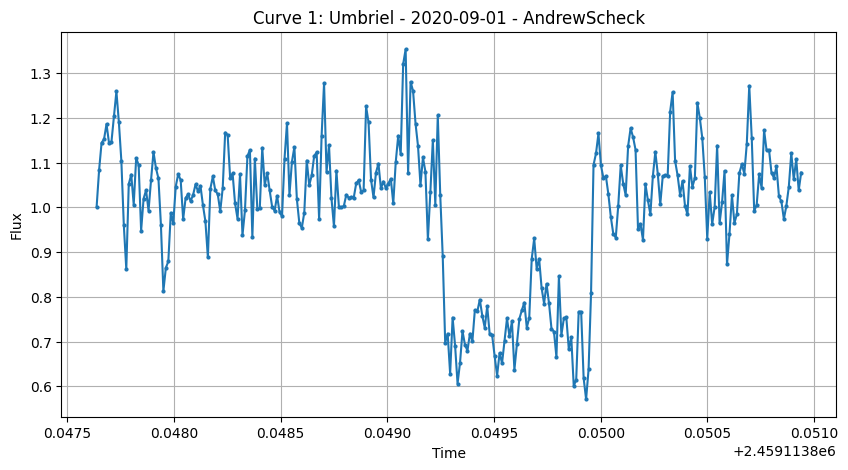

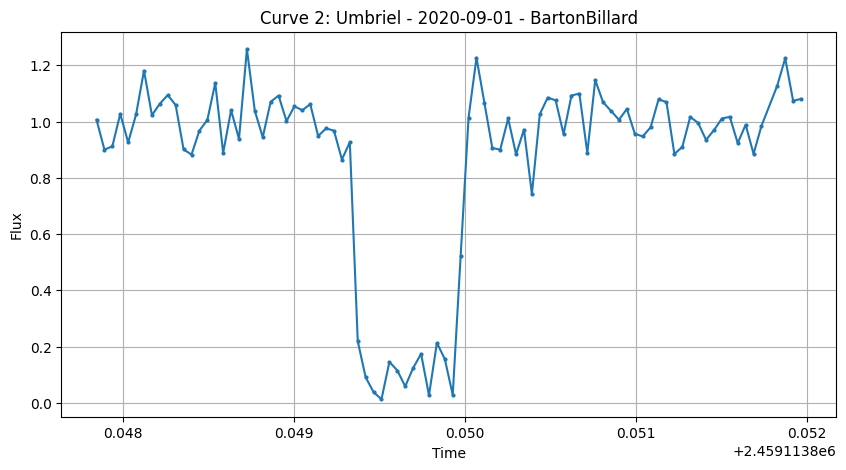

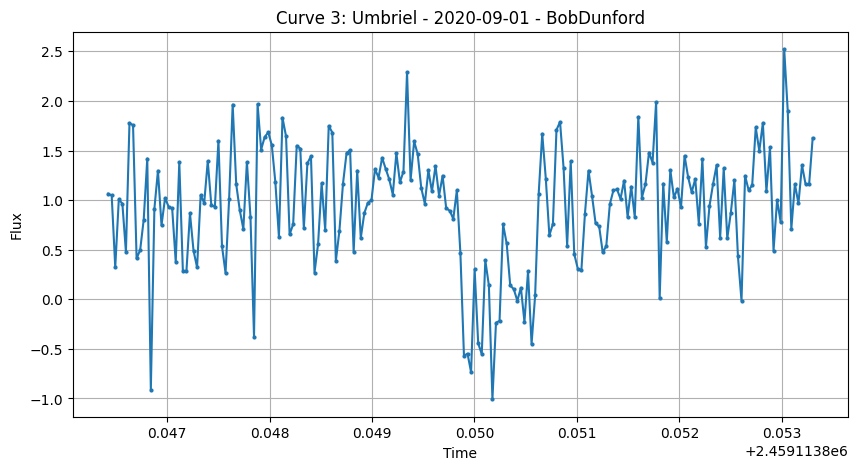

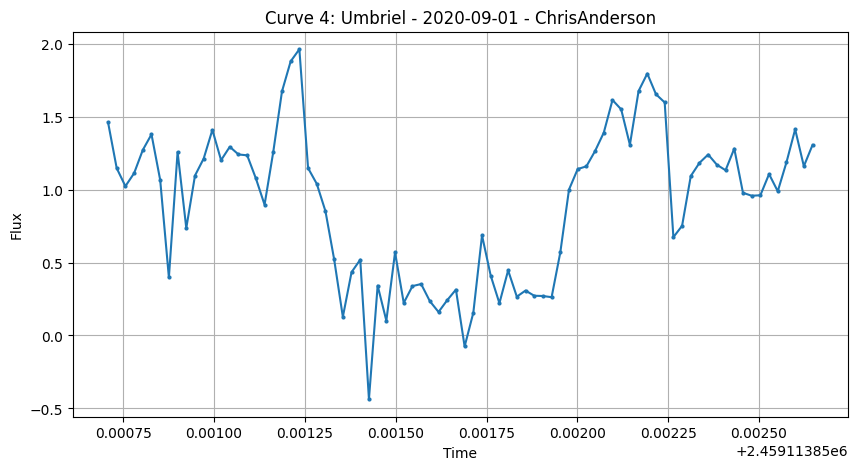

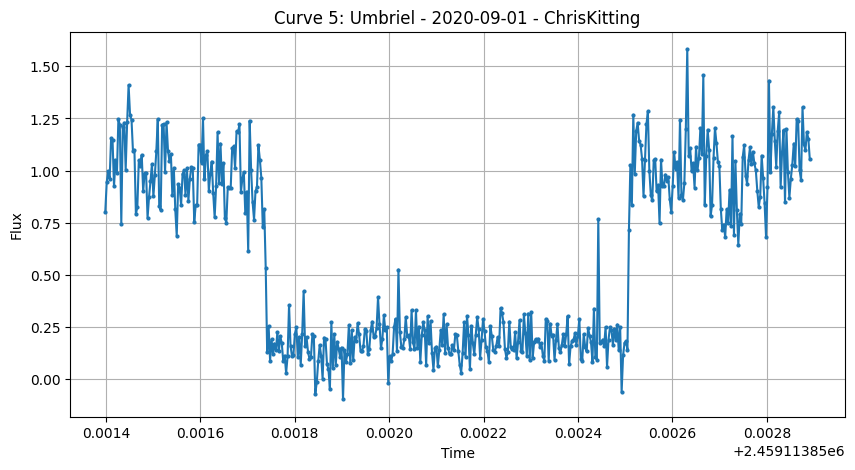

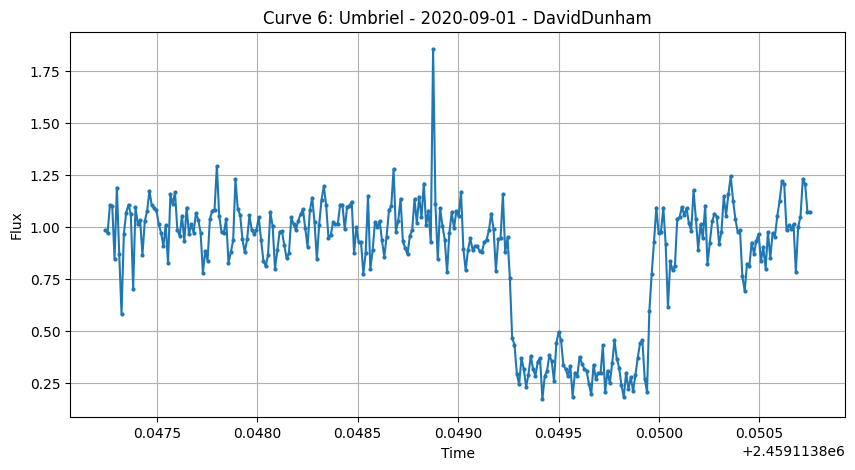

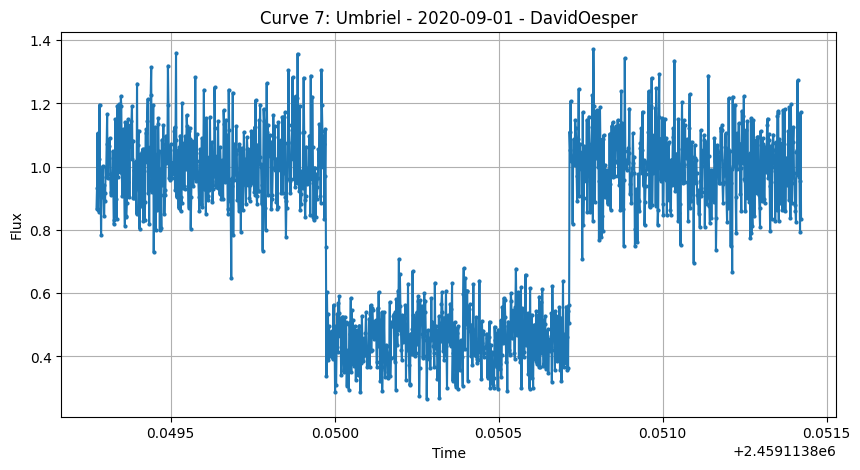

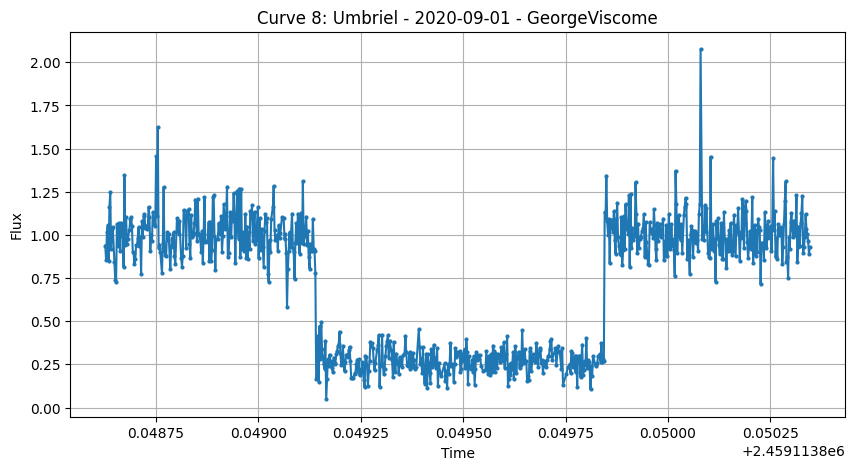

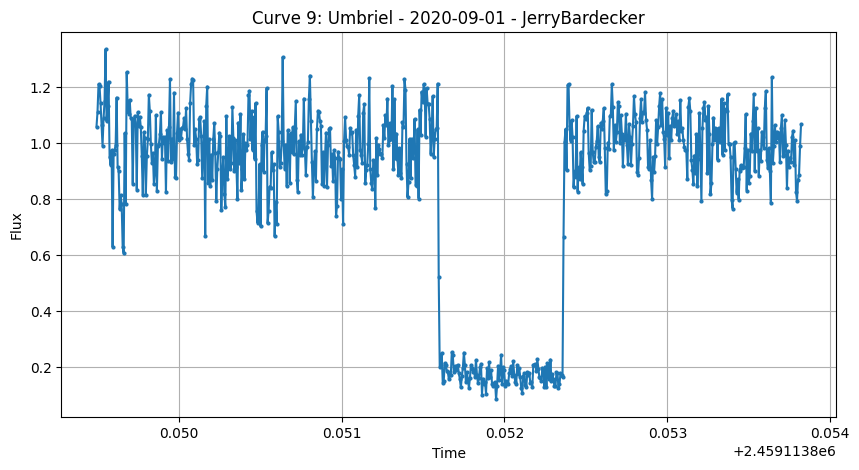

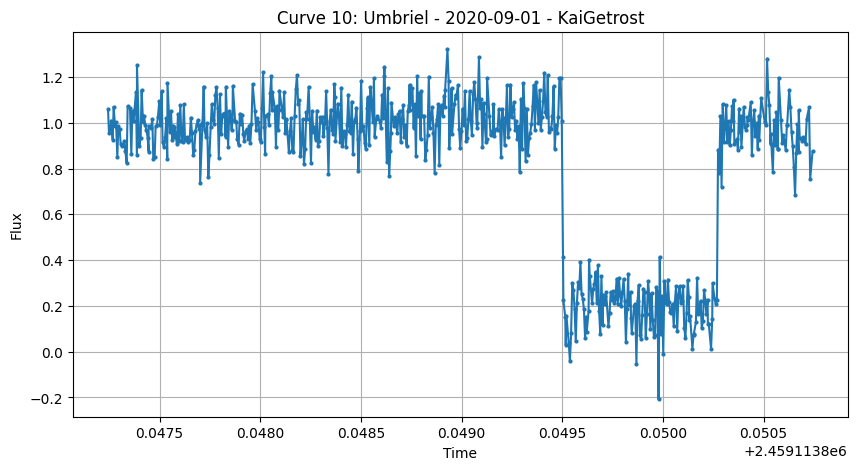

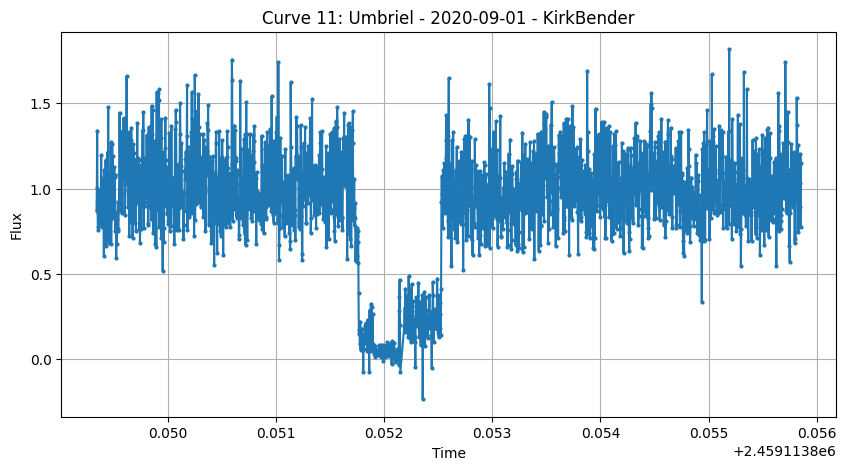

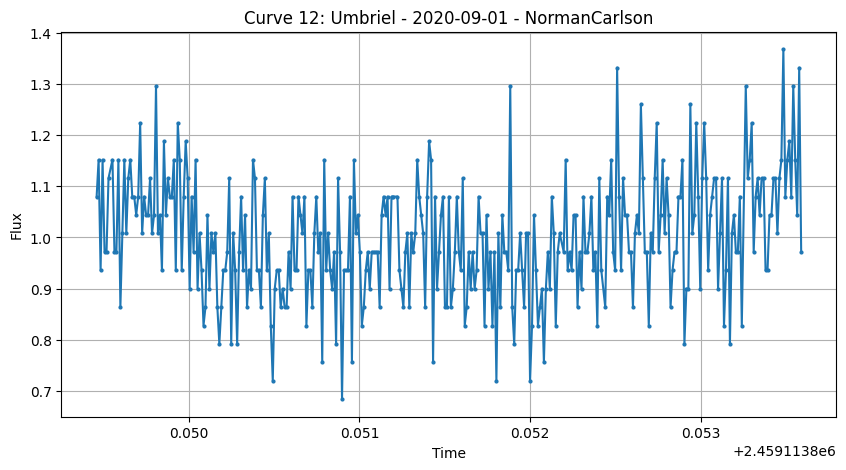

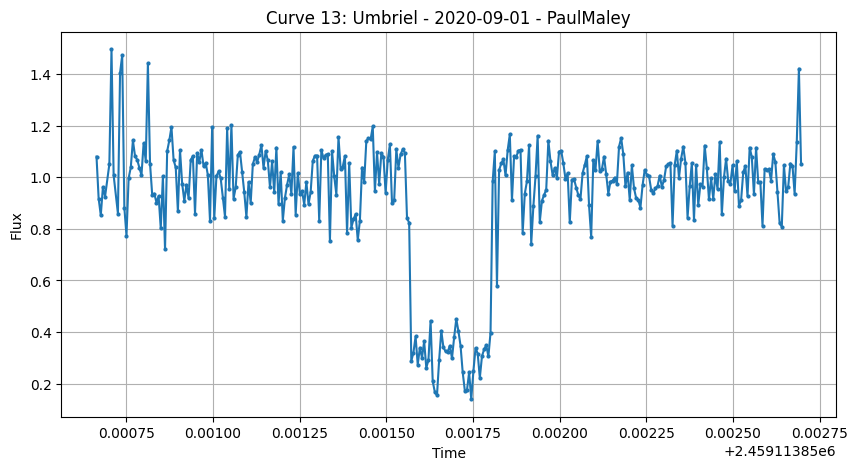

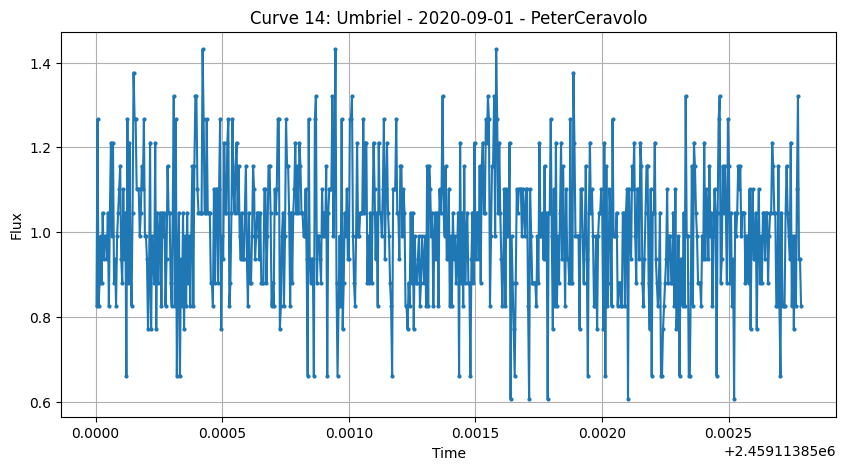

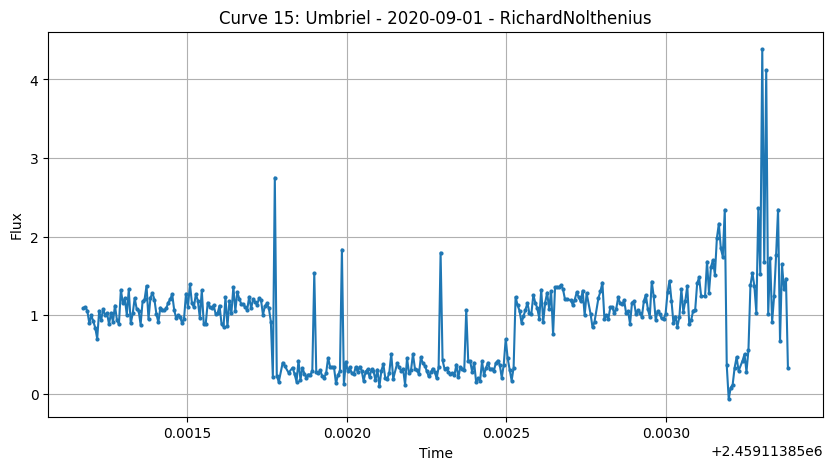

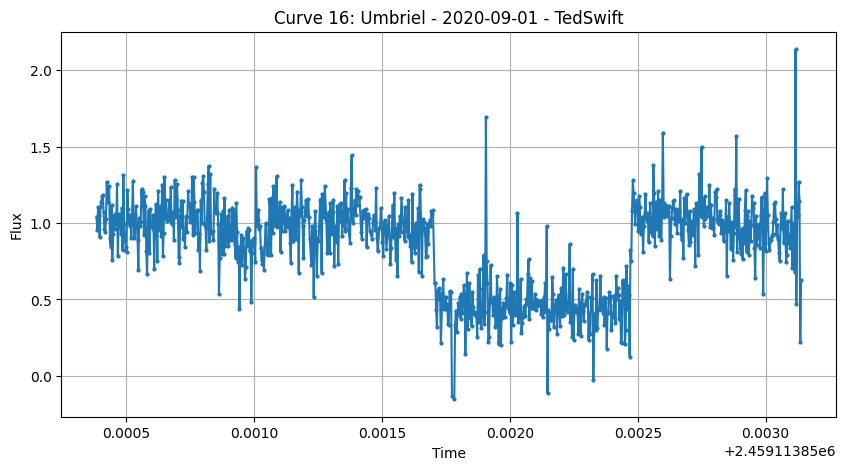

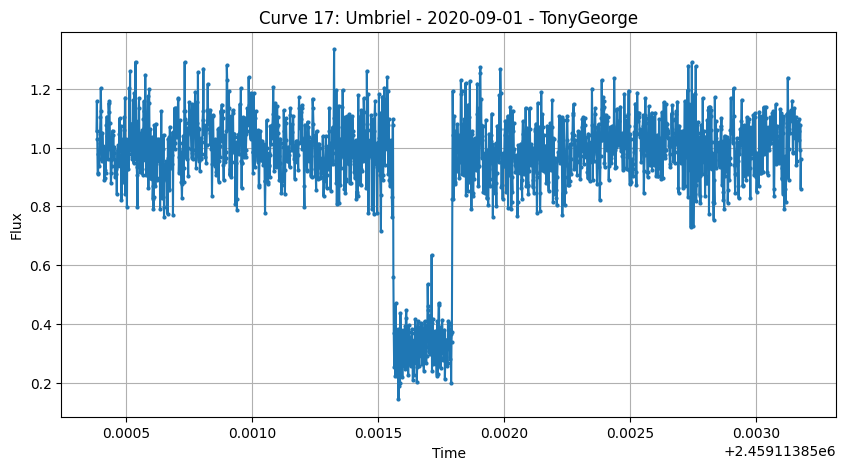

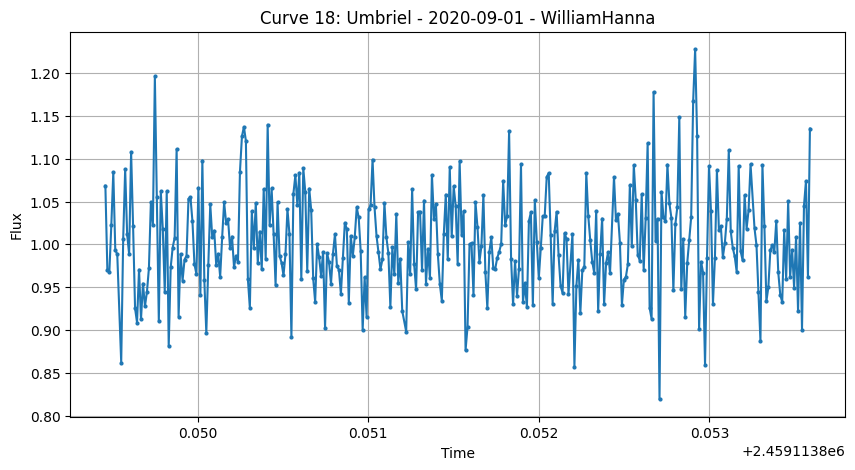

In [10]:
astro_data_access.plot_raw_curves(astro_data_access.get_all_light_curves_from_object(object_name='Umbriel'))

## 2 - Segundo passo
Ler uma amostragem grande de curvas (+100), programar um método de recortar trechos negativos e associá-los a curvas separadas negativas. 

Ideia: separar recortes em outra variável "fake_negative".

In [11]:
def recortar_negativos(curva, margem=10, threshold=0.8, min_tamanho=20, z_thresh=3):
    """
    Recorta trechos negativos (sem ocultação) de uma curva positiva, com limpeza de outliers.
    """
    import numpy as np
    import pandas as pd

    time = np.array(curva[0][0].get('time'))
    flux = np.array(curva[0][0].get('flux', 'flux_normalized'))

    # Limpeza de outliers
    time, flux = astro_data_access.remove_outliers(time, flux, z_thresh=z_thresh)

    # Identifica pontos de ocultação
    ocultando = flux < threshold
    if not np.any(ocultando):
        # Não há ocultação, retorna a curva toda como negativa
        return [pd.DataFrame({'time': time, 'flux_normalized': flux})]

    # Encontra início e fim do evento
    indices = np.where(ocultando)[0]
    inicio = indices[0]
    fim = indices[-1]

    # Trecho antes da ocultação
    antes = slice(0, max(0, inicio - margem))
    # Trecho depois da ocultação
    depois = slice(min(len(time), fim + margem), len(time))

    negativos = []
    if (antes.stop - antes.start) >= min_tamanho:
        negativos.append(pd.DataFrame({'time': time[antes], 'flux_normalized': flux[antes]}))
    if (depois.stop - depois.start) >= min_tamanho:
        negativos.append(pd.DataFrame({'time': time[depois], 'flux_normalized': flux[depois]}))

    return negativos

In [12]:
Umbriel_curves = astro_data_access.get_all_light_curves_from_object(object_name='Umbriel')

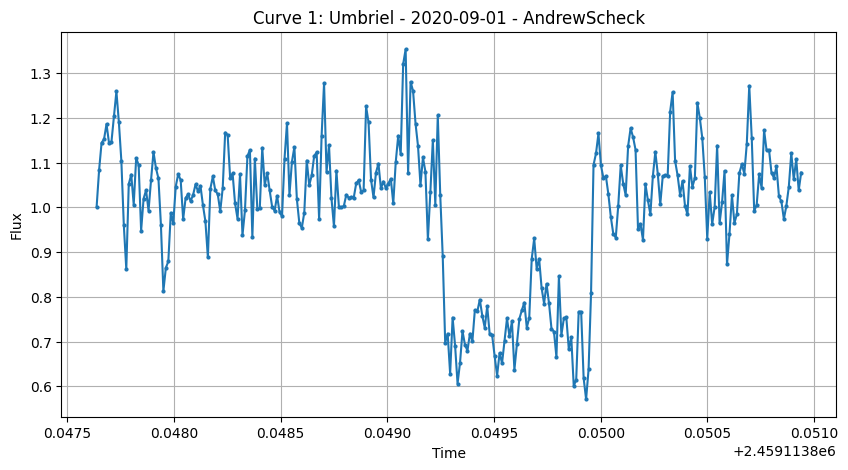

In [13]:
astro_data_access.plot_raw_curves([(Umbriel_curves[0])])

In [14]:
curve_1 = [(Umbriel_curves[0])]
negativos = recortar_negativos(curve_1)

<Axes: xlabel='time'>

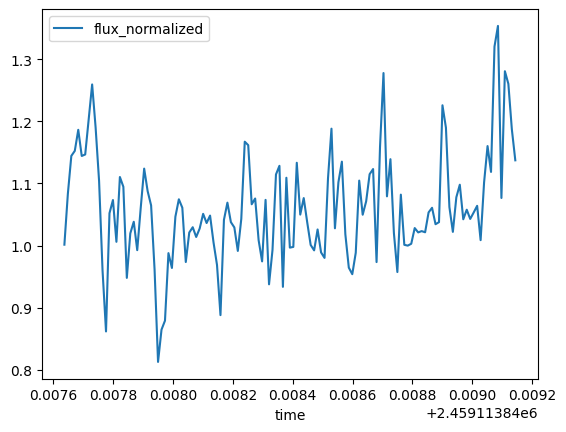

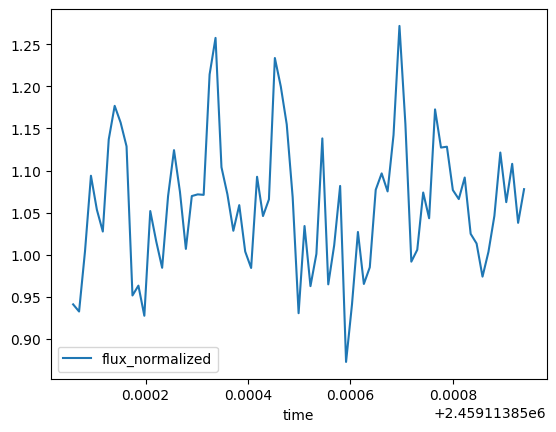

In [15]:
negativos[0].plot(x='time', y='flux_normalized')
negativos[1].plot(x='time', y='flux_normalized')

In [16]:
Umbriel_curves[-1]

({'time': [2459113.8494596,
   2459113.84947121,
   2459113.84948281,
   2459113.84949441,
   2459113.84950601,
   2459113.84951761,
   2459113.84952921,
   2459113.84955241,
   2459113.84956402,
   2459113.84957562,
   2459113.84958722,
   2459113.84959882,
   2459113.84961042,
   2459113.84962202,
   2459113.84963362,
   2459113.84964522,
   2459113.84965683,
   2459113.84966843,
   2459113.84968003,
   2459113.84969163,
   2459113.84970323,
   2459113.84971483,
   2459113.84972643,
   2459113.84973804,
   2459113.84974964,
   2459113.84976124,
   2459113.84977284,
   2459113.84978444,
   2459113.84979604,
   2459113.84980764,
   2459113.84981924,
   2459113.84983085,
   2459113.84984245,
   2459113.84985405,
   2459113.84986565,
   2459113.84987725,
   2459113.84988885,
   2459113.84990045,
   2459113.84991206,
   2459113.84992366,
   2459113.84993526,
   2459113.84994686,
   2459113.84995846,
   2459113.84997006,
   2459113.84998166,
   2459113.84999326,
   2459113.85000487,
   245

 - Comparando a curva inteira com a parte negativa recortada:

Podemos considerar essas curvas como outras negativas, para aumentar nosso dataset.

In [19]:
## guardar dataset negativo:

all_negatives_from_db = astro_data_access.get_light_curves_by_type(_type='negative', normalized=True)

In [21]:
negativos

[             time  flux_normalized
 0    2.459114e+06         1.001479
 1    2.459114e+06         1.083380
 2    2.459114e+06         1.144384
 3    2.459114e+06         1.152486
 4    2.459114e+06         1.186374
 ..            ...              ...
 126  2.459114e+06         1.076645
 127  2.459114e+06         1.280673
 128  2.459114e+06         1.260377
 129  2.459114e+06         1.187427
 130  2.459114e+06         1.137268
 
 [131 rows x 2 columns],
             time  flux_normalized
 0   2.459114e+06         0.940770
 1   2.459114e+06         0.932271
 2   2.459114e+06         1.003995
 3   2.459114e+06         1.093769
 4   2.459114e+06         1.053338
 ..           ...              ...
 72  2.459114e+06         1.121366
 73  2.459114e+06         1.062366
 74  2.459114e+06         1.107939
 75  2.459114e+06         1.037759
 76  2.459114e+06         1.077824
 
 [77 rows x 2 columns]]

## 3 - Terceiro passo
Organizar variáveis de curvas lidas, aplicar feature engineering e criar DataSet de treino/validação.

## 4 - Quarto passo
Organizar o dataset final.

## 5 - Quinto passo
Treinar os modelos!